You might need to install this on your system:

apt-get install python3-opencv git

In [ ]:
import os

if not os.path.isdir('k'):
 !git clone -b development14 https://github.com/joaopauloschuler/k-neural-api.git k
else:
 !cd k && git pull

!cd k && pip install .

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/joaopauloschuler/k-neural-api
   1b88547..370653a  development14 -> origin/development14
Updating 1b88547..370653a
Fast-forward
 cai/layers.py | 12 ++++++++++++
 1 file changed, 12 insertions(+)
Processing /content/k
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for cai: filename=cai-0.1.5-py3-none-any.whl size=57335 sha256=81323cd27ad62f7c649c145e451e146048c1602f9acb7e70ad89cc674

In [ ]:
import cai.layers
import cai.datasets
import cai.models
import cai.densenet
import cai.efficientnet
import numpy as np
from tensorflow import keras
from tensorflow.keras import mixed_precision
import gc
import multiprocessing
import random
import tensorflow as tf
print("Tensorflow version:", tf.version.VERSION)
print("Keras version:", keras.__version__)
print("CPU cores:", multiprocessing.cpu_count())
import psutil
print('RAM:', (psutil.virtual_memory().total / 1e9),'GB')
print(tf.config.list_physical_devices('GPU'))
import matplotlib.pylab as plt
from sklearn.metrics import classification_report

Tensorflow version: 2.7.0
Keras version: 2.7.0
CPU cores: 8
RAM: 54.76702208 GB
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!nvidia-smi

Sun Nov 21 20:40:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    26W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla V100-SXM2-16GB, compute capability 7.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder

def get_flops(model):
  forward_pass = tf.function(
      model.call,
      input_signature=[tf.TensorSpec(shape=(1,) + model.input_shape[1:])])

  graph_info = profile(forward_pass.get_concrete_function().graph,
                          options=ProfileOptionBuilder.float_operation())

  # The //2 is necessary since `profile` counts multiply and accumulate
  # as two flops, here we report the total number of multiply accumulate ops
  flops = graph_info.total_float_ops // 2
  return flops

In [ ]:
dataset=tf.keras.datasets.cifar10
verbose=True
lab=False
bipolar=False
base_model_name='best'
x_train, y_train, x_test, y_test = cai.datasets.load_dataset(dataset, verbose=verbose, lab=lab, bipolar=bipolar, base_model_name=base_model_name)
print(x_train.shape)
print(y_train.shape)

train shape (50000, 32, 32, 3)
test shape (10000, 32, 32, 3)
Original channel  0  min: 0.0  max: 255.0
Original channel  1  min: 0.0  max: 255.0
Original channel  2  min: 0.0  max: 255.0
Loading RGB.
Channel  0  min: 0.0  max: 1.0
Channel  1  min: 0.0  max: 1.0
Channel  2  min: 0.0  max: 1.0
(50000, 32, 32, 3)
(50000, 10)


In [ ]:
num_classes = 10
batch_size = 64
epochs = 50
target_size_x = 32
target_size_y = 32
seed = 12
input_shape = (32, 32, 3)

In [ ]:
train_datagen = cai.util.create_image_generator(validation_split=0.1, rotation_range=20, width_shift_range=0.3, height_shift_range=0.3)
test_datagen = cai.util.create_image_generator_no_augmentation()
cpus_num = max([multiprocessing.cpu_count(), 8])

def cyclical_adv_lrscheduler25(epoch):
    """CAI Cyclical and Advanced Learning Rate Scheduler.
    # Arguments
        epoch: integer with current epoch count.
    # Returns
        float with desired learning rate.
    """
    base_learning = 0.001
    local_epoch = epoch % 25
    if local_epoch < 7:
       return base_learning * (1 + 0.5*local_epoch)
    else:
       return (base_learning * 4) * ( 0.85**(local_epoch-7) )

In [ ]:
batches_per_epoch = int(45000/batch_size)
l2_decay = 0.0001 / batches_per_epoch

In [ ]:
import tensorflow
import tensorflow.keras

In [ ]:
def work_on_densenet(show_model=False, run_fit=False, test_results=False, calc_f1=False):
  monitor='val_accuracy'
  if (calc_f1): 
    test_results=True
  if (show_model):
    input_shape = (target_size_x, target_size_y, 3)
  else:
    input_shape = (None, None, 3)
  for kType in [cai.layers.D6_12ch(), cai.layers.D6_24ch()]:
      basefilename = '/content/drive/MyDrive/output/JP33B25-kDenseNet-CIFAR10-'+str(kType)
      best_result_file_name = basefilename+'-best_result.hdf5'
      print('Running: '+basefilename)
      if kType == 0:
        model = cai.densenet.simple_densenet([32, 32, 3], blocks=16, 
          growth_rate=12, bottleneck=48, compression=0.5,
          l2_decay=0, num_classes=num_classes, dropout_rate=0.0)
      else:
        model = cai.densenet.ksimple_densenet([32, 32, 3], blocks=16, 
          growth_rate=12, bottleneck=48, compression=0.5,
          l2_decay=0, kTypeBlock=kType, kTypeTransition=kType, 
          num_classes=num_classes, dropout_rate=0.0,
          activation=keras.activations.swish,
          has_interleave_at_transition=True)
      
      optimizer = keras.optimizers.RMSprop()
      optimizer = mixed_precision.LossScaleOptimizer(optimizer)
      model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy'])

      if (show_model): 
        model.summary(line_length=220)
        print('model flops:',get_flops(model))

      save_best = keras.callbacks.ModelCheckpoint(
            filepath=best_result_file_name,
            monitor=monitor,
            verbose=1,
            save_best_only=True,
            save_weights_only=False,
            mode='max',
            save_freq='epoch')

      if (run_fit):
        train_flow = train_datagen.flow(
                x_train, y_train,
                batch_size=batch_size,
                shuffle=True,
                seed=seed,
                subset='training'
            )
        validation_flow = train_datagen.flow(
                x_train, y_train,
                batch_size=batch_size,
                shuffle=True,
                seed=seed,
                subset='validation'
            )

        history = model.fit(
          x = train_flow,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=validation_flow,
          callbacks=[save_best, tf.keras.callbacks.LearningRateScheduler(cyclical_adv_lrscheduler25)],
          workers=cpus_num,
          max_queue_size=128
          )
        plt.figure()
        plt.ylabel("Accuracy (training and validation)")
        plt.xlabel("Epochs")
        plt.ylim([0,1])
        plt.plot(history.history["accuracy"])
        plt.plot(history.history["val_accuracy"])
      if (test_results):
        test_flow = test_datagen.flow(
            x_test, y_test,
            batch_size=batch_size,
            shuffle=True,
            seed=seed
            )
        print('Best Model Results: '+best_result_file_name)
        model = cai.models.load_kereas_model(best_result_file_name)
        evaluated = model.evaluate(
            x=test_flow,
            batch_size=batch_size,
            use_multiprocessing=False,
            workers=cpus_num
        )
        for metric, name in zip(evaluated,["loss","acc"]):
              print(name,metric)
      if (calc_f1):
        pred_y = model.predict(x_test)
        print("Predicted Shape:", pred_y.shape)
        pred_classes_y = np.array(list(np.argmax(pred_y, axis=1)))
        test_classes_y = np.array(list(np.argmax(y_test, axis=1)))
        print("Pred classes shape:",pred_classes_y.shape)
        print("Test classes shape:",test_classes_y.shape)
        report = classification_report(test_classes_y, pred_classes_y, digits=4)
        print(report)
      print('Finished: '+basefilename)

In [ ]:
work_on_densenet(show_model=True, run_fit=False, test_results=False)

Running: /content/drive/MyDrive/output/JP33B25-kDenseNet-CIFAR10-40
Model: "model"
____________________________________________________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                                           Output Shape                                     Param #                   Connected to                                                             
 input_1 (InputLayer)                                                   [(None, 32, 32, 3)]                              0                         []                                                                       
                                                                                                                                                                                                                            
 conv2d (Conv2D)                 

Running: /content/drive/MyDrive/output/JP33B25-kDenseNet-CIFAR10-40
Epoch 1/50
704/704 [==============================] - ETA: 0s - loss: 1.5610 - accuracy: 0.4290
Epoch 00001: val_accuracy improved from -inf to 0.47040, saving model to /content/drive/MyDrive/output/JP33B25-kDenseNet-CIFAR10-40-best_result.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


704/704 [==============================] - 170s 191ms/step - loss: 1.5610 - accuracy: 0.4290 - val_loss: 1.5068 - val_accuracy: 0.4704 - lr: 0.0010
Epoch 2/50
704/704 [==============================] - ETA: 0s - loss: 1.2130 - accuracy: 0.5699
Epoch 00002: val_accuracy improved from 0.47040 to 0.48940, saving model to /content/drive/MyDrive/output/JP33B25-kDenseNet-CIFAR10-40-best_result.hdf5
704/704 [==============================] - 132s 187ms/step - loss: 1.2130 - accuracy: 0.5699 - val_loss: 1.5525 - val_accuracy: 0.4894 - lr: 0.0015
Epoch 3/50
704/704 [==============================] - ETA: 0s - loss: 1.0438 - accuracy: 0.6343
Epoch 00003: val_accuracy improved from 0.48940 to 0.63780, saving model to /content/drive/MyDrive/output/JP33B25-kDenseNet-CIFAR10-40-best_result.hdf5
704/704 [==============================] - 132s 187ms/step - loss: 1.0438 - accuracy: 0.6343 - val_loss: 1.0465 - val_accuracy: 0.6378 - lr: 0.0020
Epoch 4/50
704/704 [==============================] - ETA: 0

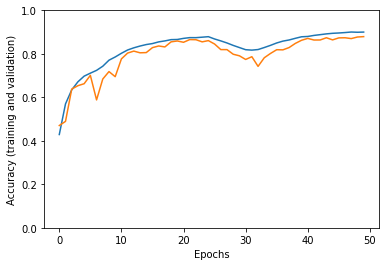

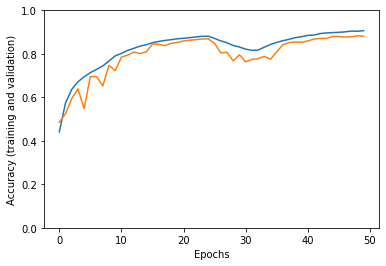

In [ ]:
work_on_densenet(show_model=False, run_fit=True, test_results=True)

In [ ]:
work_on_densenet(show_model=False, run_fit=False, test_results=True)

Running: /content/drive/MyDrive/output/JP33B25-kDenseNet-CIFAR10-40
Best Model Results: /content/drive/MyDrive/output/JP33B25-kDenseNet-CIFAR10-40-best_result.hdf5
157/157 [==============================] - 11s 45ms/step - loss: 0.3021 - accuracy: 0.9083
loss 0.302113801240921
acc 0.90829998254776
Finished: /content/drive/MyDrive/output/JP33B25-kDenseNet-CIFAR10-40
Running: /content/drive/MyDrive/output/JP33B25-kDenseNet-CIFAR10-41
Best Model Results: /content/drive/MyDrive/output/JP33B25-kDenseNet-CIFAR10-41-best_result.hdf5
157/157 [==============================] - 11s 45ms/step - loss: 0.2991 - accuracy: 0.9063
loss 0.29912781715393066
acc 0.9063000082969666
Finished: /content/drive/MyDrive/output/JP33B25-kDenseNet-CIFAR10-41
